In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint, Bounds

In [ ]:
file_path = "/content/drive/MyDrive/Cleaned_Data/alt1_data.csv"

df = pd.read_csv(file_path, index_col = 0)
df.head(2)

,AAPL,ABCB,ACGL,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,...,VLY,VRTX,WABC,WAFD,WBA,WERN,WSFS,WTFC,XEL,ZION
Date,,,,,,,,,,,,,,,,,,,,,
1995-01-04,0.026058,-0.01031,NaN,-0.027484,-0.026217,-0.004273,0.0301,0.011407,-0.006211,0.025000,...,0.022322,-0.050000,0.0,0.021126,0.0,-0.016043,0.035715,NaN,0.002825,-0.018965
1995-01-05,-0.012699,0.00000,NaN,0.039131,0.009616,0.006438,0.0000,0.000000,0.012500,-0.004878,...,0.013100,-0.008772,0.0,0.033231,0.0,-0.010870,0.068965,NaN,0.002817,0.008787


In [ ]:
#df["Date"] = pd.to_datetime(df["Date"])

In [ ]:
df.iloc[1261]

AAPL    0.024922
ABCB    0.024096
ACGL   -0.028846
ADBE    0.018939
ADI     0.028334
          ...   
WERN    0.013514
WSFS    0.041238
WTFC    0.025210
XEL    -0.003806
ZION    0.009595
Name: 1999-12-31, Length: 111, dtype: float64

# 1 Classical Mean Variance Approach

From 1.1 to 1.4, there is an experimentation with the models and packages used, which culminates in the construction of the efficient frontier. But the data that matters the most for the analysis carried out in the paper is in section 1.5. (still look at the end of the intro to understand functions used)

## Intro

In [ ]:
split_point = int((len(df)/2))   #Point which was intended for dividing in-sample and out-of-sample data for backtesting
print(split_point)
print(type(split_point))
split_date = df.iloc[split_point].name  #Date intended to divide the in-sample and out-of-sample data for backtesting
print(split_date)

2547
<class 'int'>
2010-02-19


In [ ]:
in_sample = df.iloc[: split_point]   #In the end, I decided to include all the data in the backtest, but I used this sub-sample to practice and illustrate the Mean-Variance model used, as well as the efficient frontier.
in_sample.head()

,AAPL,ABCB,ACGL,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,...,VLY,VRTX,WABC,WAFD,WBA,WERN,WSFS,WTFC,XEL,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.088754,0.011765,-0.089109,-0.025093,-0.030242,-0.034803,-0.011111,-0.021400,-0.001480,0.071274,...,-0.037946,0.073214,-0.080537,-0.069620,-0.023504,-0.031111,-0.029703,-0.032787,-0.025641,-0.062302
2000-01-04,-0.084310,-0.011628,-0.005435,-0.083889,-0.050590,0.000000,-0.048689,0.011928,-0.049407,-0.056452,...,-0.051044,-0.079867,-0.017031,-0.023809,-0.037199,-0.002294,-0.030612,0.000000,0.023026,-0.048424
2000-01-05,0.014634,0.000000,0.092896,0.019771,0.014599,-0.009615,-0.062992,0.037328,-0.037422,0.025641,...,0.000000,-0.016275,0.032178,0.010029,0.011364,0.016092,0.005263,0.016949,0.038585,-0.001183
2000-01-06,-0.086538,0.000000,-0.010000,0.008163,-0.027339,0.013350,-0.060925,0.005682,0.001619,0.066667,...,0.012225,-0.014706,0.002398,0.006993,-0.029214,-0.004987,0.005236,0.000000,-0.009287,0.014218
2000-01-07,0.047368,0.011765,0.055556,0.048583,0.028107,0.022755,0.118568,0.013182,0.008626,0.015625,...,-0.012078,0.087687,0.014354,0.020833,0.025463,0.029613,-0.005208,-0.029166,0.000000,0.002337


In [ ]:
stock_mreturns = np.mean(in_sample, axis = 0)
annualized_returns = np.power(1 + stock_mreturns, 252) - 1  #(1 + Mean Daily Returns)^251 - 1 = Mean Annualized Returns (252 trading days per year on average) This method of annualizing is the most mathematically exact
print(annualized_returns) #We have expected annual returns of each stock, but we need expected returns of the portfolio

AAPL    0.405875
ABCB    0.230142
ACGL    0.242420
ADBE    0.240428
ADI     0.113272
          ...   
WERN    0.217402
WSFS    0.179728
WTFC    0.251015
XEL     0.123221
ZION    0.049321
Length: 110, dtype: float64


In [ ]:
#Create the covariance matrix (sigma) of returns of the stocks, in order to calculate the volatility of the portfolio later
covar = in_sample.cov()*252     #Annualized using the simple method

In [ ]:
def portfolio_gross_return (r, w):
  "Expected return of the portfolio is the weighted average of returns of the assets composing it. Not adjusted for costs. Return as % of capital invested"
  #r represents the returns of each asset
  #w represents the weights that go to each asset
  return r.dot(w)

def adjusted_portfolio_return (portfolio_gross_return, desired_weights, transaction_cost):
  "Desired weights are those obtained from the optimization. Transaction cost input: as a % of transaction, meaning as a % of weight rebalancing"
  num_assets = len(desired_weights)
  initial_weights = np.ones(num_assets) / num_assets

  vector_transaction_costs = transaction_cost * np.abs(initial_weights - desired_weights)
  total_transaction_costs = np.sum(vector_transaction_costs)
  adjusted_return = portfolio_gross_return - total_transaction_costs
  return adjusted_return

def portfolio_volatility (w, covar):
  "Portfolio volatility is the following matrix multiplication: w^T . covariance_matrix . w"
  vol = np.sqrt(np.dot(w.T, np.dot(covar, w)))
  return vol

## 1.1 Minimum Variance Portfolio

In [ ]:
def minimum_risk_portfolio (expected_returns, covariance_matrix):
  "This optimization method will find the highest return possible that one can get with the minimum risk: we will minimize the portfolio volatility"
  num_assets = len(expected_returns)

  #Set the weight constraints: all of them should be between 0 and 1 because we are working with a no-short strategy
  bounds = Bounds(0, 1)

  #Sum of weights should also equal 1 (100% of our capital)
  constraint_matrix = np.ones((1, num_assets))
  linear_constraint = LinearConstraint(constraint_matrix, [1], [1])

  #Initial portfolio allocation is the equally weighted portfolio
  initial_weights = np.ones(num_assets) / num_assets

  #Calculate portfolio volatility (but we do this because the function "minimize" needs a function as input in the first argument, not a function call)
  def port_vol (initial_weights, covariance_matrix):
    port_vol = portfolio_volatility(initial_weights, covariance_matrix)
    return port_vol

  result = minimize(port_vol, initial_weights, args = (covariance_matrix), method = "trust-constr", constraints = linear_constraint, bounds = bounds)

  return result


In [ ]:
MVP = minimum_risk_portfolio(annualized_returns, covar)
MVP.x   #Optimal weights(stored in a row vector array)

array([5.55172738e-06, 3.69419917e-07, 8.29500182e-02, 8.67444219e-07,
       2.00397228e-06, 2.20094144e-02, 2.17772307e-06, 2.63449063e-02,
       1.09732166e-06, 7.40515601e-07, 2.13279111e-02, 1.42549553e-06,
       7.72535670e-06, 6.92531374e-07, 5.21550006e-07, 6.52625979e-02,
       3.54852315e-06, 5.73285429e-07, 1.92060072e-06, 1.67370791e-06,
       1.51506202e-06, 1.04983598e-05, 7.54990396e-07, 9.86599204e-07,
       4.43518684e-07, 2.60779218e-06, 1.33059980e-02, 1.19909768e-06,
       1.88058341e-01, 8.69458537e-07, 1.02104426e-06, 5.14383516e-07,
       4.55767887e-03, 7.86949891e-03, 1.20333779e-06, 6.09422867e-06,
       2.15357051e-06, 1.51247060e-06, 1.21281118e-06, 5.69766988e-07,
       8.84676399e-04, 2.66981699e-06, 6.51489488e-02, 4.47626752e-06,
       4.90108280e-07, 1.10961527e-02, 1.10760830e-06, 9.56987164e-03,
       3.34355295e-02, 7.69747919e-07, 2.04495676e-06, 3.25411955e-07,
       5.90038072e-07, 8.34591615e-07, 7.07570504e-07, 5.55114135e-06,
      

In [ ]:
#Optimal weights, returns and volatility for the volatility minimization
MVP_weights = MVP.x
MVP_grossret = portfolio_gross_return(annualized_returns, MVP_weights)
MVP_vol = portfolio_volatility(MVP_weights, covar)
MVP_cost = 0.01   # 1% of each transaction
MVP_ret = adjusted_portfolio_return(MVP_grossret, MVP_weights, MVP_cost)
MVP_sharperatio = MVP_ret / MVP_vol

print("MVP Strategy:")
print("% Return:", MVP_grossret)
print("Volatility:", MVP_vol)
print("% Adjusted Return:", MVP_ret)
print("MVP Sharpe Ratio:", MVP_sharperatio)

MVP Strategy:
% Return: 0.16332420578185305
Volatility: 0.15790681496296272
% Adjusted Return: 0.14706826680695387
MVP Sharpe Ratio: 0.9313611121942328


## 1.2 Benchmark

In [ ]:
#Benchmark
num_stocks = len(annualized_returns)
equal_weights = np.ones(num_stocks) / num_stocks

bench_ret = portfolio_gross_return(annualized_returns, equal_weights)  #No transaction costs because we do not rebalance
bench_vol = portfolio_volatility(equal_weights, covar)
bench_sharperatio = bench_ret / bench_vol

print("Equally-weighted Strategy:")
print("% Return:", bench_ret)
print("Volatility:", bench_vol)
print("MVP Sharpe Ratio:", bench_sharperatio)

Equally-weighted Strategy:
% Return: 0.18759366644921846
Volatility: 0.25228758882472624
MVP Sharpe Ratio: 0.7435707294326988


## 1.3 Sharpe Ratio Optimization

In [ ]:
# To maximize the Sharpe Ratio we minimize 1/Sharpe Ratio
starting_weights = np.ones(num_stocks) / num_stocks

def negative_sharpe_ratio(weights, covar_matrix, expected_returns):
  portfolio_vol = portfolio_volatility(weights, covar_matrix)
  portfolio_ret = portfolio_gross_return(expected_returns, weights)
  return -portfolio_ret / portfolio_vol  # negative value for minimization

def sharperatio_max (weights, covar_matrix, expected_returns):

  # All weights must be between 0 and 1, so set 0 and 1 as the boundaries.
  bounds = Bounds(0, 1)

  # Set the constraint that the sum of weights equals 1.
  constraint_matrix = np.ones((1, num_stocks))
  linear_constraint = LinearConstraint(constraint_matrix, [1], [1])

  def neg_sh (weights, covar_matrix, expected_returns):
    sh = negative_sharpe_ratio(weights, covar_matrix, expected_returns)
    return sh

  # Minimize the negative Sharpe ratio (to maximize Sharpe ratio) using 'trust-constr' method with constraints and bounds.
  res_sharpe = minimize(negative_sharpe_ratio, weights, args = (covar_matrix, expected_returns), method='trust-constr', constraints=linear_constraint, bounds=bounds)

  return res_sharpe

In [ ]:
sharpe_optimization = sharperatio_max(weights = starting_weights, covar_matrix = covar, expected_returns = annualized_returns)
sharpe_weights = sharpe_optimization.x
sharpe_grossret = portfolio_gross_return(annualized_returns, sharpe_weights)
sharpe_vol = portfolio_volatility(sharpe_weights, covar)
sharpe_cost = 0.01
sharpe_adjret = adjusted_portfolio_return(sharpe_grossret, sharpe_weights, sharpe_cost)
sharpe_shratio = sharpe_adjret / sharpe_vol

print("% Return:", sharpe_grossret)
print("Volatility:", sharpe_vol)
print("Adj. Return:", sharpe_adjret)
print("Sharpe Ratio:", sharpe_shratio)

% Return: 0.4680683844132768
Volatility: 0.23998522708782657
Adj. Return: 0.4504308166131504
Sharpe Ratio: 1.8769106002025189


## 1.4 Efficient Frontier

In [ ]:
# Function to generate random weight combinations
def generate_random_weights_beta(num_stocks, num_combinations, alpha, beta):
    return np.random.beta(alpha, beta, size=(num_combinations, num_stocks))

# Function to calculate returns and volatilities for random weight combinations
def calculate_portfolio_metrics(returns, covar, weights):
    gross_returns = []
    volatilities = []
    for w in weights:
        gross_returns.append(portfolio_gross_return(returns.T, w))  # Transpose annualized_returns
        volatilities.append(portfolio_volatility(w, covar))
    return np.array(gross_returns), np.array(volatilities)

In [ ]:
# Function to plot efficient frontier
def plot_efficient_frontier(gross_returns, volatilities, MVP_weights, equal_weights, sharpe_weights):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, gross_returns, label='Random Weight Combinations', color='blue')
    plt.scatter(portfolio_volatility(MVP_weights, covar), portfolio_gross_return(annualized_returns, MVP_weights) , marker='*', label='Minimum Risk (Efficient) Portfolio', color='red', s=175)
    plt.scatter(portfolio_volatility(equal_weights, covar), portfolio_gross_return(annualized_returns, equal_weights) , marker='o', label='Equal Weight Portfolio', color='green', s=100)
    plt.scatter(portfolio_volatility(sharpe_weights, covar), portfolio_gross_return(annualized_returns, sharpe_weights), marker='^', label='Maximum Sharpe Ratio Portfolio', color='orange', s=175)

    # Logarithmic curve connecting MVP and Sharpe Portfolio
    x_vals = np.logspace(np.log10(MVP_vol), np.log10(sharpe_vol), 150)
    curve_returns = MVP_grossret + np.log(x_vals - MVP_vol + 1) * (sharpe_grossret - MVP_grossret) / np.log(sharpe_vol - MVP_vol + 1)
    plt.plot(x_vals, curve_returns, label='(Illustrative)Efficient Frontier', color='turquoise', linestyle=':', linewidth = 6) #Not the real efficient frontier

    # Extrapolate the curve beyond the Sharpe Portfolio point
    max_return = 1.5
    max_volatility = 1
    x_vals = np.logspace(np.log10(sharpe_vol), np.log10(max_volatility), 150)
    curve_returns = sharpe_grossret + np.log(x_vals - sharpe_vol + 1) * (max_return - sharpe_grossret) / np.log(max_volatility - sharpe_vol + 1)
    plt.plot(x_vals, curve_returns, color = "turquoise", linestyle=':', linewidth = 6)


    # Add labels and title
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.title('Efficient Frontier with Optimal Portfolios')
    plt.legend()

    # Show plot
    plt.grid(False)
    plt.show()

In [ ]:
# Generate random weight combinations
num_stocks = len(annualized_returns)
num_combinations = 10000


# Generate random weight combinations using a Beta distribution
alpha = 0.08 # Shape parameter
beta = 4   # Shape parameter
random_weights = generate_random_weights_beta(num_stocks, num_combinations, alpha, beta)

# Calculate returns and volatilities for random weight combinations
random_gross_returns, random_volatilities = calculate_portfolio_metrics(annualized_returns, covar, random_weights)

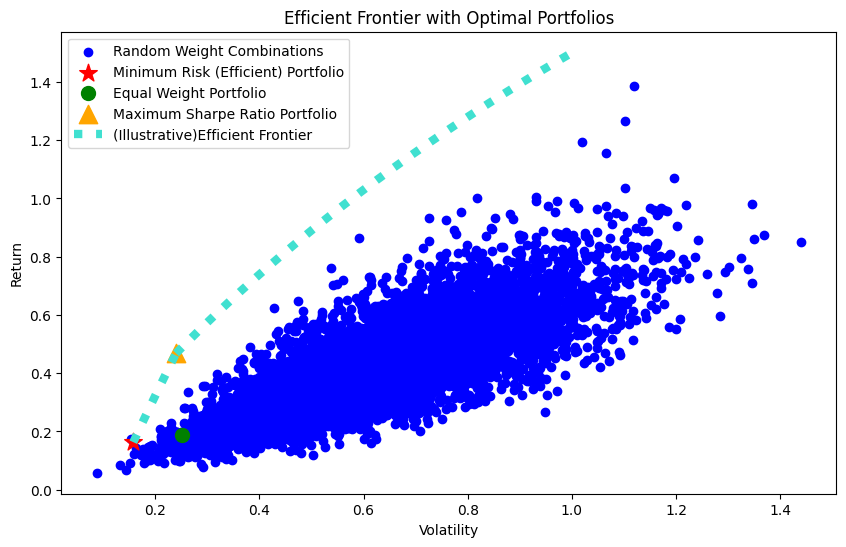

In [ ]:
# Plot efficient frontier
plot_efficient_frontier(random_gross_returns, random_volatilities, MVP_weights, equal_weights, sharpe_weights)


## 1.5 Backtesting of Mean Variance


### 1.5.1 Intro

In [ ]:
#Slight adjustment of the previous functions for the purpose of backtesting

def adjusted_port_return (portfolio_gross_return, initial_weights,  desired_weights, transaction_rate):
  "Desired weights are those obtained from the optimization. Transaction rate represents the % of transactions (change in weights) that represent costs"
  #We think of transaction costs calculation as a % of returns derived from the rate of weight changes that represent costs
  # % adjusted return = % gross return - % transaction cost
  #                 = % gross return - (sum(transaction_rate * weight changes))
  # Recall that because we used the .pct_change() pandas function to calculate returns, all returns are percentage returns

  vector_transaction_costs = transaction_rate * np.abs(initial_weights - desired_weights)
  total_transaction_costs = np.sum(vector_transaction_costs)
  adjusted_return = portfolio_gross_return - total_transaction_costs
  return adjusted_return

#MVP Optimization Model
def minimum_variance_portfolio (covariance_matrix, initial_weights):
  "This optimization method will find the highest return possible that one can get with the minimum risk: we will minimize the portfolio volatility"
  num_assets = len(initial_weights)

  #Set the weight constraints: all of them should be between 0 and 1 because we are working with a no-short strategy
  bounds = Bounds(0, 1)

  #Sum of weights should also equal 1 (100% of our capital)
  constraint_matrix = np.ones((1, num_assets))
  linear_constraint = LinearConstraint(constraint_matrix, [1], [1])

  #Calculate portfolio volatility (but we do this because the function "minimize" needs a function as input in the first argument, not a function call)
  def port_vol (initial_weights, covariance_matrix):
    port_vol = portfolio_volatility(initial_weights, covariance_matrix)
    return port_vol

  result = minimize(port_vol, initial_weights, args = (covariance_matrix), method = "trust-constr", constraints = linear_constraint, bounds = bounds)

  return result

  #Max Sharpe Ratio Optimization Model
def neg_sharpe_ratio(weights, covar_matrix, expected_returns):
  portfolio_vol = portfolio_volatility(weights, covar_matrix)
  portfolio_ret = portfolio_gross_return(expected_returns, weights)
  return -portfolio_ret / portfolio_vol  # negative value for minimization

def sharpe_ratio_max (weights, covar_matrix, expected_returns):

  num_stocks = len(weights)

  # All weights must be between 0 and 1, so set 0 and 1 as the boundaries.
  bounds = Bounds(0, 1)

  # Set the constraint that the sum of weights equals 1.
  constraint_matrix = np.ones((1, num_stocks))
  linear_constraint = LinearConstraint(constraint_matrix, [1], [1])

  def neg_sh (weights, covar_matrix, expected_returns):
    sh = neg_sharpe_ratio(weights, covar_matrix, expected_returns)
    return sh

  # Minimize the negative Sharpe ratio (to maximize Sharpe ratio) using 'trust-constr' method with constraints and bounds.
  res_sharpe = minimize(neg_sh, weights, args = (covar_matrix, expected_returns), method='trust-constr', constraints=linear_constraint, bounds=bounds)

  return res_sharpe

### 1.5.2 MVP Backtesting

In [ ]:
# Function to backtest the Minimum-Variance optimization strategy with annual rebalancing
def backtest_Min_Risk_strategy(returns, transaction_cost_rate):
    num_assets = len(returns.columns)       #Returns meaning our daily return data: our dataframe
    num_days = len(returns)
    rebalancing_period = 252  # Number of trading days in a year
    investing_capital = 10000   #The capital to be used with this strategy
    initial_transaction_cost = np.sum(np.dot(np.ones(num_assets), 1/num_assets)) * transaction_cost_rate #Initial transaction cost (in %) resulting from buying the equally weighted portfolio (from 0 weighting to 1/n)
    initial_portfolio_value = investing_capital - initial_transaction_cost * investing_capital  #The amount we would invest, adjusted for initial cost. And we will see how it evolves over time
    portfolio_value = initial_portfolio_value
    portfolio_values = [initial_portfolio_value]
    adjusted_returns = []
    portfolio_volatilities = []
    previous_weights = np.ones(num_assets) / num_assets  # Initial equally weighted portfolio

    for day in range(num_days):
        if (day % rebalancing_period == 0 and day > 1761) or day == 1762:    #We start re-balancing from the 2000s onwards. Before that, we have the in-sample data, which feeds the covariance statistic.

            # Calculate covariance matrix using data up to this point (for MVP I don't need expected return)
            in_sample_data = returns.iloc[:day]
            covariance_matrix = in_sample_data.cov(numeric_only = True) * 252               #Simple Annualizing Method (with assumptions IID)

            # Calculate minimum variance portfolio
            MVP = minimum_variance_portfolio(covariance_matrix, previous_weights)
            weights = MVP.x

            # Calculate portfolio returns (daily)
            portfolio_return = portfolio_gross_return(returns.iloc[day], weights)

            # Adjust returns for transaction costs
            adjusted_return = adjusted_port_return(portfolio_return, previous_weights, weights, transaction_cost_rate )

            # Store adjusted returns
            adjusted_returns.append(adjusted_return)

            # Update portfolio value
            portfolio_value = portfolio_values[-1] * (1 + adjusted_return)

            # Store portfolio value
            portfolio_values.append(portfolio_value)

            # Recalculate portfolio volatility and store value (daily)
            covariance_matrix = in_sample_data.cov(numeric_only = True)
            portfolio_volatility_value = portfolio_volatility(weights, covariance_matrix)
            portfolio_volatilities.append(portfolio_volatility_value)

            #In the next period, optimized weights in this period will be the previous weights
            previous_weights = weights

        elif day > 1261 and day != 1762:

            # Calculate portfolio returns (daily)
            portfolio_return = portfolio_gross_return(returns.iloc[day], previous_weights)

            #If there is no rebalancing, there are no transaction costs for this period
            adjusted_return = portfolio_return

            # Store adjusted returns
            adjusted_returns.append(adjusted_return)

            # Update portfolio value
            portfolio_value = portfolio_values[-1] * (1 + adjusted_return)

            # Store portfolio value
            portfolio_values.append(portfolio_value)

            #Calculate the covariance up to this point, to track volatility (even if we do not rebalance we calculate volatility)
            covar_data = returns.iloc[:day]
            covar_matrix = covar_data.cov(numeric_only = True)

            # Recalculate portfolio volatility (daily) and store value
            portfolio_volatility_value = portfolio_volatility(previous_weights, covar_matrix)
            portfolio_volatilities.append(portfolio_volatility_value)

        else:
            continue

    return portfolio_values, adjusted_returns, portfolio_volatilities

In [ ]:
transaction_rate = 0.01   #We define it as 1% of transactions (rebalancing)

MVP_portfolio_values, MVP_adjusted_returns, MVP_portfolio_volatilities = backtest_Min_Risk_strategy(df, transaction_rate)

### 1.5.3 Max Sharpe Backtesting

In [ ]:
# Function to backtest the Max-Sharpe optimization strategy with annual rebalancing
def backtest_Max_Sharpe_strategy(returns, transaction_cost_rate):
    num_assets = len(returns.columns)       #Returns meaning our daily return data: our dataframe
    num_days = len(returns)
    rebalancing_period = 252  # Number of trading days in a year
    investing_capital = 10000   #The capital to be used with this strategy
    initial_transaction_cost = np.sum(np.dot(np.ones(num_assets), 1/num_assets)) * transaction_cost_rate #Initial transaction cost (in %) resulting from buying the equally weighted portfolio (from 0 weighting to 1/n)
    initial_portfolio_value = investing_capital - initial_transaction_cost * investing_capital  #The amount we would invest, adjusted for initial cost. And we will see how it evolves over time
    portfolio_value = initial_portfolio_value
    portfolio_values = [initial_portfolio_value]
    adjusted_returns = []
    portfolio_volatilities = []
    previous_weights = np.ones(num_assets) / num_assets  # Initial equally weighted portfolio

    for day in range(num_days):
        if (day % rebalancing_period == 0 and day > 1761) or day == 1762:     #We start re-balancing from the 2000s onwards. Before that, we have in-sample data, feeding the average and the covariance statistics.

            # Calculate expected returns and covariance matrix using data up to this point
            in_sample_data = returns.iloc[:day]
            expected_returns = in_sample_data.mean()
            expected_returns = np.power(1 + expected_returns, 252) - 1   #Analytical Annualizing method
            covariance_matrix = in_sample_data.cov(numeric_only = True) * 252               #Simple Annualizing Method (with assumptions IID)

            # Calculate Max Sharpe portfolio
            Max_Sharpe = sharpe_ratio_max(previous_weights, covariance_matrix, expected_returns)
            weights = Max_Sharpe.x

            # Calculate portfolio returns (daily)
            portfolio_return = portfolio_gross_return(returns.iloc[day], weights)

            # Adjust returns for transaction costs
            adjusted_return = adjusted_port_return(portfolio_return, previous_weights, weights, transaction_cost_rate )

            # Store adjusted returns
            adjusted_returns.append(adjusted_return)

            # Update portfolio value
            portfolio_value = portfolio_values[-1] *(1 + adjusted_return)

            # Store portfolio value
            portfolio_values.append(portfolio_value)

            # Recalculate portfolio volatility (daily) and store value
            covariance_matrix = in_sample_data.cov(numeric_only = True)
            portfolio_volatility_value = portfolio_volatility(weights, covariance_matrix)
            portfolio_volatilities.append(portfolio_volatility_value)

            #In the next period, optimized weights in this period will be the previous weights
            previous_weights = weights

        elif day > 1261 and day != 1762:

            # Calculate portfolio returns(daily)
            portfolio_return = portfolio_gross_return(returns.iloc[day], previous_weights)

            #If there is no rebalancing, there are no transaction costs for this period
            adjusted_return = portfolio_return

            # Store adjusted returns
            adjusted_returns.append(adjusted_return)

            # Update portfolio value
            portfolio_value = portfolio_values[-1] *(1 + adjusted_return)

            # Store portfolio value
            portfolio_values.append(portfolio_value)

            #Calculate the covariance up to this point, to track volatility (even if we do not rebalance we calculate volatility)
            covar_data = returns.iloc[:day]
            covar_matrix = covar_data.cov(numeric_only = True)

            # Recalculate portfolio volatility (daily) and store value
            portfolio_volatility_value = portfolio_volatility(previous_weights, covar_matrix)
            portfolio_volatilities.append(portfolio_volatility_value)

        else:
            continue

    return portfolio_values, adjusted_returns, portfolio_volatilities

In [ ]:
#We use the same transaction rate = 0.01 or 1% of transactions
transaction_rate = 0.01

Max_shp_portfolio_values, Max_shp_adjusted_returns, Max_shp_portfolio_volatilities = backtest_Max_Sharpe_strategy(df, transaction_rate)

### 1.5.4 Benchmark Backtesting

In [ ]:
# Function to backtest the Max-Sharpe optimization strategy with annual rebalancing
def backtest_benchmark_strategy(returns, transaction_cost_rate):
    num_assets = len(returns.columns)       #Returns meaning our daily return data: our dataframe
    num_days = len(returns)
    investing_capital = 10000   #The capital to be used with this strategy
    initial_transaction_cost = np.sum(np.dot(np.ones(num_assets), 1/num_assets)) * transaction_cost_rate #Initial transaction cost (in %) resulting from buying the equally weighted portfolio (from 0 weighting to 1/n)
    initial_portfolio_value = investing_capital - initial_transaction_cost * investing_capital  #The amount we would invest, adjusted for initial cost. And we will see how it evolves over time
    portfolio_value = initial_portfolio_value
    portfolio_values = [initial_portfolio_value]
    adjusted_returns = []
    portfolio_volatilities = []
    weights = np.ones(num_assets) / num_assets  # Equally weighted portfolio

    for day in range(num_days):

      if day >= 1262:   #We start after in-sample data.

          # Calculate portfolio returns (daily)
          portfolio_return = portfolio_gross_return(returns.iloc[day], weights)

          #If there is no rebalancing, there are no transaction costs
          adjusted_return = portfolio_return

          # Store adjusted returns
          adjusted_returns.append(adjusted_return)

          # Update portfolio value
          portfolio_value = portfolio_values[-1] * (1 + adjusted_return)

          # Store portfolio value
          portfolio_values.append(portfolio_value)

          #Calculate the covariance up to this point, to track volatility (even if we do not rebalance we calculate volatility)
          covar_data = returns.iloc[:day]
          covar_matrix = covar_data.cov()

          # Recalculate portfolio volatility (daily) and store value
          portfolio_volatility_value = portfolio_volatility(weights, covar_matrix)
          portfolio_volatilities.append(portfolio_volatility_value)

      else:
          continue

    return portfolio_values, adjusted_returns, portfolio_volatilities

In [ ]:
#We use the same transaction rate = 0.01 or 1% of transactions
transaction_rate = 0.01

benchmark_portfolio_values, benchmark_adjusted_returns, benchmark_portfolio_volatilities = backtest_benchmark_strategy(df, transaction_rate)

### 1.5.5 Comparison Plots

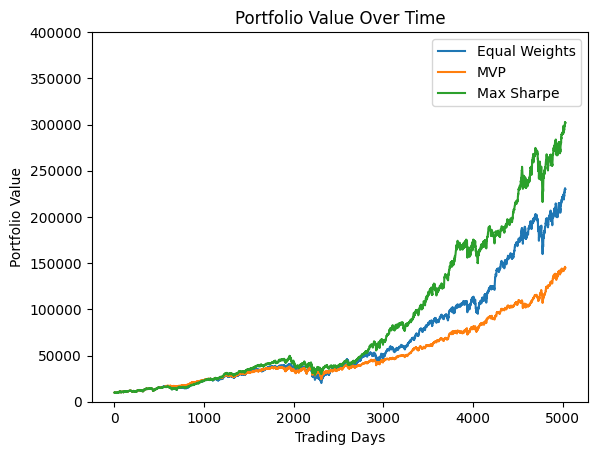

In [ ]:
#In this plot we exclude COVID time because the downturn is misleading for visualization, and it is also the start of a new business cycle beyond the scope of the backtest.
plt.plot(benchmark_portfolio_values[0:5030], label = "Equal Weights")
plt.plot(MVP_portfolio_values[0:5030] , label = "MVP")
plt.plot(Max_shp_portfolio_values[0:5030], label = "Max Sharpe")
plt.title("Portfolio Value Over Time")
plt.xlabel("Trading Days")
plt.ylabel("Portfolio Value")
plt.ylim(0, 400000)
plt.legend()
plt.show()

In [ ]:
print(benchmark_portfolio_values[5030])
print(MVP_portfolio_values[5030])
print(Max_shp_portfolio_values[5030])

229511.9893415624
144587.5557713558
301338.08687641466


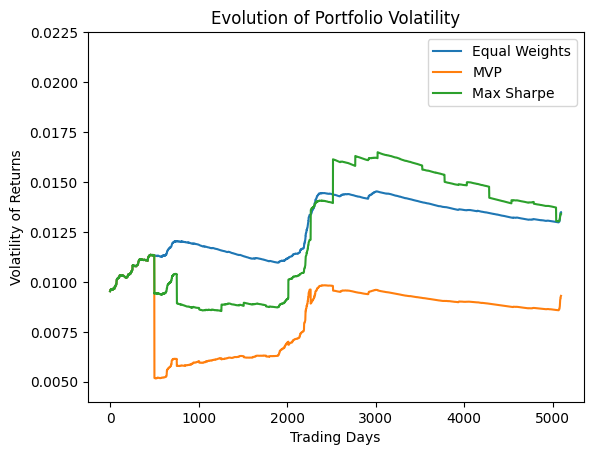

In [ ]:
plt.plot(benchmark_portfolio_volatilities, label = "Equal Weights")
plt.plot(MVP_portfolio_volatilities, label = "MVP")
plt.plot(Max_shp_portfolio_volatilities, label = "Max Sharpe")
plt.title("Evolution of Portfolio Volatility")
plt.xlabel("Trading Days")
plt.ylabel("Volatility of Returns")
plt.ylim(0.004, 0.0225)
plt.legend()
plt.show()

In [ ]:
MVP_returns_and_vol = pd.DataFrame({"MVP Portfolio Returns": MVP_adjusted_returns, "MVP Volatility": MVP_portfolio_volatilities })
MVP_returns_and_vol = MVP_returns_and_vol.dropna()
len(MVP_returns_and_vol)

5094

In [ ]:
MVP_returns_and_vol["Rolling Sharpe Ratio"] = np.sqrt(252)*(MVP_returns_and_vol["MVP Portfolio Returns"].rolling(252).mean() / MVP_returns_and_vol["MVP Volatility"].rolling(252).mean())   #.mean() is the only method that worked. But also, it's like the yearly average value of the volatility. It still makes sense. .std() does not make sense because we already have the standard deviation
MVP_returns_and_vol = MVP_returns_and_vol[0:5001] #COVID Drop
MVP_returns_and_vol

,MVP Portfolio Returns,MVP Volatility,Rolling Sharpe Ratio
0,-0.015221,0.009530,NaN
1,-0.031324,0.009540,NaN
2,0.007812,0.009588,NaN
3,-0.005534,0.009587,NaN
4,0.019973,0.009588,NaN
...,...,...,...
4996,0.000791,0.008617,1.490695
4997,0.000489,0.008616,1.464247
4998,0.004987,0.008616,1.520642
4999,0.000641,0.008615,1.494016


In [ ]:
benchmark_returns_and_vol = pd.DataFrame({"Benchmark Portfolio Returns": benchmark_adjusted_returns, "Benchmark Volatility": benchmark_portfolio_volatilities })
benchmark_returns_and_vol = benchmark_returns_and_vol.dropna()
len(benchmark_returns_and_vol)

5094

In [ ]:
benchmark_returns_and_vol["Rolling Sharpe Ratio"] = np.sqrt(252)* (benchmark_returns_and_vol["Benchmark Portfolio Returns"].rolling(252).mean() / benchmark_returns_and_vol["Benchmark Volatility"].rolling(252).mean())
benchmark_returns_and_vol = benchmark_returns_and_vol[0:5001]  #COVID Drop
benchmark_returns_and_vol

,Benchmark Portfolio Returns,Benchmark Volatility,Rolling Sharpe Ratio
0,-0.015221,0.009530,NaN
1,-0.031324,0.009540,NaN
2,0.007812,0.009588,NaN
3,-0.005534,0.009587,NaN
4,0.019973,0.009588,NaN
...,...,...,...
4996,-0.001480,0.013031,0.824069
4997,0.002219,0.013030,0.882820
4998,-0.002759,0.013028,0.956787
4999,0.000714,0.013028,0.942867


In [ ]:
Maxsharpe_returns_and_vol = pd.DataFrame({"Max Shp Portfolio Returns": Max_shp_adjusted_returns, "Max Shp Volatility": Max_shp_portfolio_volatilities })
Maxsharpe_returns_and_vol = Maxsharpe_returns_and_vol.dropna()
print(len(Maxsharpe_returns_and_vol))
Maxsharpe_returns_and_vol.head()

5094


,Max Shp Portfolio Returns,Max Shp Volatility
0,-0.015221,0.009530
1,-0.031324,0.009540
2,0.007812,0.009588
3,-0.005534,0.009587
4,0.019973,0.009588


In [ ]:
Maxsharpe_returns_and_vol["Rolling Sharpe Ratio"] = np.sqrt(252)* (Maxsharpe_returns_and_vol["Max Shp Portfolio Returns"].rolling(252).mean() / Maxsharpe_returns_and_vol["Max Shp Volatility"].rolling(252).mean())
Maxsharpe_returns_and_vol = Maxsharpe_returns_and_vol[0:5001]  #Dropping the last row because of COVID times again
Maxsharpe_returns_and_vol

,Max Shp Portfolio Returns,Max Shp Volatility,Rolling Sharpe Ratio
0,-0.015221,0.009530,NaN
1,-0.031324,0.009540,NaN
2,0.007812,0.009588,NaN
3,-0.005534,0.009587,NaN
4,0.019973,0.009588,NaN
...,...,...,...
4996,0.000857,0.013761,0.605693
4997,-0.000869,0.013760,0.604481
4998,-0.000629,0.013758,0.693021
4999,0.000788,0.013757,0.683580


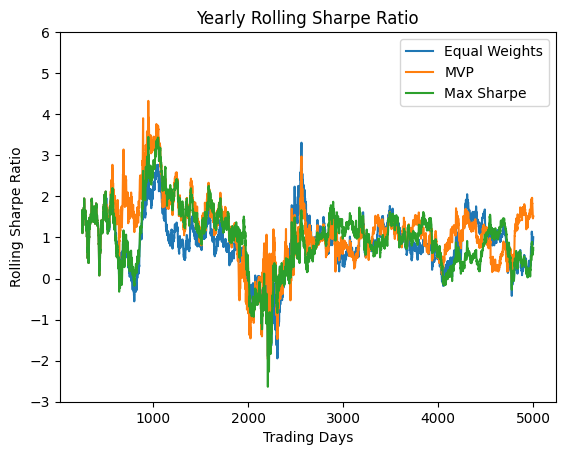

In [ ]:
plt.plot(benchmark_returns_and_vol["Rolling Sharpe Ratio"].dropna(), label = "Equal Weights")   #Droping rows of NaN values
plt.plot(MVP_returns_and_vol["Rolling Sharpe Ratio"].dropna(), label = "MVP")
plt.plot(Maxsharpe_returns_and_vol["Rolling Sharpe Ratio"].dropna(), label = "Max Sharpe")
plt.title("Yearly Rolling Sharpe Ratio")
plt.xlabel("Trading Days")
plt.ylabel("Rolling Sharpe Ratio")
plt.ylim(-3, 6)
plt.legend()
plt.show()